<a href="https://colab.research.google.com/github/EddyGiusepe/NLP_with_Disaster_Tweets_Transfer_Learning/blob/main/4_Transfer_Learning_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Text Classification - Transfer Learning</h2>


Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.7 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
# Importamos a nossas bibliotecas necessárias

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


import torchtext
from torchtext.legacy.data import Field, LabelField
from torchtext.legacy import data

In [ ]:
PATH = Path('/content/drive/MyDrive/5_Scripts_in_Python_Eddy/3_SENSIO_ML_DL/Kaggle_NLP_with_Disaster_Tweets/data_Tweets')

os.listdir(PATH)


['sample_submission.csv',
 'test.csv',
 'train.csv',
 'train_clean.csv',
 'test_clean.csv',
 'submission.csv']

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.2 MB/s 
     |████████████████████████████████| 6.6 MB 47.7 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Exemplo:

tokens = tokenizer.tokenize('#Hello WORLD how ARE you? ... Thanks God!')
tokens

['#',
 'hello',
 'world',
 'how',
 'are',
 'you',
 '?',
 '.',
 '.',
 '.',
 'thanks',
 'god',
 '!']

In [ ]:
tokenizer.convert_tokens_to_ids(tokens)

[1001, 7592, 2088, 2129, 2024, 2017, 1029, 1012, 1012, 1012, 4283, 2643, 999]

In [ ]:
# Os transformers trabalham com comprimento de sequencia determinada (não seq-to-seq)

max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length) # Não podemos ter frases maiores a este valor

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

512


In [ ]:
ID = data.RawField()
KEYWORD = data.RawField()
LOCATION = data.RawField()

# Aqui aplicamos o Tokenizador do BERT, ...
TEXT = data.Field(batch_first = True,
                  use_vocab = False, # é passado um vocabulário (do Bert)
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)

LABEL = data.LabelField(dtype = torch.long)

dataset = data.TabularDataset(
    path = PATH / 'train.csv',
    format = 'CSV',
    fields = [('id', ID), ('keyword', KEYWORD), ('location', LOCATION), ('text', TEXT), ('target', LABEL)],
    skip_header = True
)

len(dataset)

7613

In [ ]:
ix = 0

print(vars(dataset.examples[ix]))

{'id': '1', 'keyword': '', 'location': '', 'text': [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035], 'target': '1'}


In [ ]:
train_dataset, valid_dataset = dataset.split(
    split_ratio=0.75,
    stratified=True,
    strata_field='target'
)

len(train_dataset), len(valid_dataset)

(5709, 1904)

In [ ]:
LABEL.build_vocab(train_dataset)


In [ ]:
len(LABEL.vocab)

2

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = {
    'train': data.BucketIterator(train_dataset, batch_size=64, shuffle=True, device=device),
    'val': data.BucketIterator(valid_dataset, batch_size=100, device=device)
}

In [ ]:
from transformers import BertModel

class BERT(torch.nn.Module):
    def __init__(self, hidden_size=128, num_layers=2, n_outputs=2, bidirectional=True, dropout=0):
        super().__init__()
        
        #self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        for name, param in self.bert.named_parameters():                
            param.requires_grad = False
        
        self.rnn = torch.nn.LSTM(
            input_size=self.bert.config.to_dict()['hidden_size'], 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_outputs)
        
    def forward(self, text):
        with torch.no_grad():# Para que não calcule gradientes
            embedded = self.bert(text)[0]
        output, _ = self.rnn(embedded)
        # [bs, l, h]
        return self.fc(output[:,-1,:].squeeze(1))

In [ ]:
import sklearn.metrics as m
from tqdm import tqdm

def fit(model, dataloader, epochs=10, lr=1e-3):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    hist = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}
    best_f1 = 0.
    for e in range(1, epochs+1):
        model.train()
        l, f1s = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            optimizer.zero_grad()
            y_pred = model(batch.text)
            loss = criterion(y_pred, batch.target)
            l.append(loss.item())
            loss.backward()
            optimizer.step()
            y_pred = torch.argmax(y_pred, axis=1)
            f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
            bar.set_description(f"loss {np.mean(l):.5f} f1 {np.mean(f1s):.5f}")
        hist['loss'].append(np.mean(l))
        hist['f1'].append(np.mean(f1s))
        model.eval()
        l, acc, f1s = [], [], []
        with torch.no_grad():
            pg_bar = tqdm(dataloader['val'])
            for batch in pg_bar:
                y_pred = model(batch.text)
                loss = criterion(y_pred, batch.target)
                l.append(loss.item())          
                y_pred = torch.argmax(y_pred, axis=1)
                f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
                pg_bar.set_description(f"val_loss {np.mean(l):.5f} val_f1 {np.mean(f1s):.5f}")
        hist['val_loss'].append(np.mean(l))
        hist['val_f1'].append(np.mean(f1s))
        if hist["val_f1"][-1] > best_f1:
            best_f1 = hist["val_f1"][-1]
            torch.save(model.state_dict(), 'ckpt.pt')
        print(f'Epoch {e}/{epochs} loss {hist["loss"][-1]:.5f} f1 {hist["f1"][-1]:.5f} val_loss {hist["val_loss"][-1]:.5f} val_f1 {hist["val_f1"][-1]:.5f}')
    model.load_state_dict(torch.load('ckpt.pt'))
    return hist

In [ ]:
model = BERT()

hist = fit(model, dataloader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
val_loss 0.63427 val_f1 0.55354: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 1/10 loss 0.66432 f1 0.33960 val_loss 0.63427 val_f1 0.55354


val_loss 0.60776 val_f1 0.60049: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 2/10 loss 0.62994 f1 0.53468 val_loss 0.60776 val_f1 0.60049


val_loss 0.59177 val_f1 0.57337: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


Epoch 3/10 loss 0.62476 f1 0.52073 val_loss 0.59177 val_f1 0.57337


val_loss 0.45034 val_f1 0.78084: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


Epoch 4/10 loss 0.51332 f1 0.69340 val_loss 0.45034 val_f1 0.78084


val_loss 0.45416 val_f1 0.74075: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 5/10 loss 0.43175 f1 0.75388 val_loss 0.45416 val_f1 0.74075


val_loss 0.41982 val_f1 0.77742: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 6/10 loss 0.40041 f1 0.78047 val_loss 0.41982 val_f1 0.77742


val_loss 0.41880 val_f1 0.77059: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


Epoch 7/10 loss 0.38353 f1 0.79064 val_loss 0.41880 val_f1 0.77059


val_loss 0.41531 val_f1 0.79743: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 8/10 loss 0.36454 f1 0.80866 val_loss 0.41531 val_f1 0.79743


val_loss 0.44499 val_f1 0.77424: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 9/10 loss 0.35725 f1 0.81270 val_loss 0.44499 val_f1 0.77424


val_loss 0.45869 val_f1 0.78336: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


Epoch 10/10 loss 0.34092 f1 0.81812 val_loss 0.45869 val_f1 0.78336


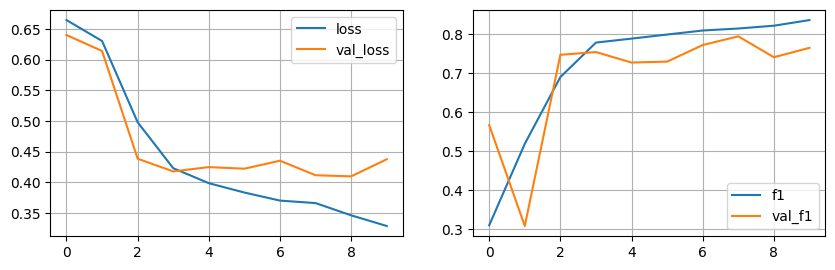

In [ ]:
def plot(hist):
    fig = plt.figure(dpi=100,figsize=(10,3))
    ax = plt.subplot(121)
    hist = pd.DataFrame(hist)
    hist[['loss', 'val_loss']].plot(ax=ax, grid=True)
    ax = plt.subplot(122)
    hist[['f1', 'val_f1']].plot(ax=ax, grid=True)
    plt.show()
    
plot(hist)

In [ ]:
test_dataset = data.TabularDataset(
    path = PATH / 'test.csv',
    format = 'CSV',
    fields = [('id', ID), ('keyword', KEYWORD), ('location', LOCATION), ('text', TEXT)],
    skip_header = True
)

len(test_dataset)

3263

In [ ]:
ix = 3258

print(vars(test_dataset.examples[ix]))

{'id': '10861', 'keyword': '', 'location': '', 'text': [8372, 3808, 3050, 3349, 1057, 2080, 3808, 3435, 24454, 2015, 1060, 2099, 7962]}


In [ ]:
test_dataloader = data.BucketIterator(test_dataset, batch_size=64, shuffle=False, device=device)


In [ ]:
def predict():
    model.eval()
    preds = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            y_pred = model(batch.text)        
            y_pred = torch.argmax(y_pred, axis=1)
            preds = torch.cat([preds, y_pred])
    return preds

In [ ]:
preds = predict()

preds

100%|██████████| 51/51 [00:06<00:00,  8.25it/s]


tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [ ]:
submission = pd.read_csv(PATH  / 'sample_submission.csv')

submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
submission.target = preds.cpu().long()
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submission.to_csv('submission.csv', index=False)